In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip
import copy
import pickle as pk
import heapq as hp

import networkx as nx
from networkx.algorithms import bipartite, components, shortest_paths

# Importing the datasets, cleaning, transforming

## Import

**Instacart datasets** (provided) : https://www.instacart.com/datasets/grocery-shopping-2017 . The instacart datasets consist in a group of 5 different datasets, each adopting a different point of view 
* "products", a dataset based on the product point of view, describing to which aisle and department it belongs to
* "aisles", a dataset that enriches "products" by describing each aisle formally
* "departments", a dataset that enriches "products" by describing each department formally
* "orders", a dataset based on the order point of view, describing when it was purchased
* "order_products_prior", a dataset based on both the order and product point of view, associating each order with the products that were purchased

After loading the datasets, we verify whether there are any missing values. 

In [2]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [3]:
products.isnull().values.any()

False

In [4]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
aisles.isnull().values.any()

False

In [6]:
aisles.size

268

In [7]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
departments.isnull().values.any()

False

In [9]:
print(departments.size)
departments.head(50)

42


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [10]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
orders.isnull().values.sum()==orders['days_since_prior_order'].isnull().values.sum()

True

In [12]:
orders.size

23947581

The missing values in _orders_ appear to correspond to the date of "previous order", when it happens to be the first one.

In [13]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1.0,1.0
1,2,28985,2.0,1.0
2,2,9327,3.0,0.0
3,2,45918,4.0,1.0
4,2,30035,5.0,0.0


In [14]:
history.isnull().values.any()

True

There are no unexpected NaN values in any of the Instacart datasets.

## Gathering all datasets

**Create a dataset with all useful information gathered : products_litteral**

We first add the names of the aisle and department in the _products_ dataset, instead of the ID, by merging the datasets :

In [15]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [16]:
products_litteral.to_pickle('products_litteral.pk')

In [178]:
products_litteral = pd.read_pickle('products_litteral.pk')

In [16]:
nb_prods_per_dept = products_litteral.groupby('department').count().sort_values(by='product_id')
nb_prods_per_dept.head(50)

,product_id,product_name,aisle
department,,,
bulk,38,38,38
other,548,548,548
meat seafood,907,907,907
pets,972,972,972
alcohol,1054,1054,1054
babies,1081,1081,1081
breakfast,1115,1115,1115
international,1139,1139,1139
missing,1258,1258,1258


**Dealing with 'missing' values**


In [17]:
missing = products_litteral[(products_litteral.department =='missing') | (products_litteral.aisle=='missing')]
missing.head(20)

,product_id,product_name,aisle,department
42813,38,Ultra Antibacterial Dish Liquid,missing,missing
42814,72,Organic Honeycrisp Apples,missing,missing
42815,110,Uncured Turkey Bologna,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,missing,missing
42818,437,Strawberry Cheesecake Nonfat Yogurt,missing,missing
42819,440,Crossovers Olive Thyme Almond,missing,missing
42820,472,Fancy Diced Hot Chilies,missing,missing
42821,491,Pompelmo Water,missing,missing
42822,556,Bake & Break Cheese Garlic Loaf,missing,missing


We can see many products don't have any name for the aisle and/or department

In [18]:
print("There are %d products with 'missing' aisle/department. This represent %0.1f%% of the products." %(missing.shape[0], missing.shape[0]/products_litteral.shape[0]*100))

There are 1258 products with 'missing' aisle/department. This represent 2.5% of the products.


The unlabelled products seem to come from many different categories, and represent a small fraction of our dataset. We decide in a first approach to let them in our work dataset, but to treat them carefully. In further steps, we may remove them or find a way to associate them with their correct aisle and department.

In [19]:
#products_litteral = products_litteral.drop(missing.index)

In [16]:
del(products)
#del(missing)

### Start graphs

In [24]:
orders_products = pd.merge(orders, history, on='order_id').drop(['add_to_cart_order', 'reordered'], axis=1)

KeyboardInterrupt: 

In [ ]:
orders_products.to_pickle('orders_products.pk')

In [184]:
orders_products = pd.read_pickle('orders_products.pk')

EOFError: 

In [18]:
food_depts = ['bulk', 'meat seafood', 'snacks', 'beverages', 'frozen', 'dairy eggs', 'canned goods', 'dry goods pasta', 'produce', 'bakery', 'deli', 'breakfast', 'alcohol', 'pantry', 'international']

In [19]:
food_aisles = {row.aisle for i, row in products_litteral.iterrows() if row.department in food_depts}

In [21]:
with open('food_aisles.pk', 'wb') as file:
    pk.dump(food_aisles, file)

In [3]:
# Here
with open('food_aisles.pk', 'rb') as file:
    food_aisles = pk.load(file)

In [7]:
by_aisle = {}
for aisle in food_aisles:
    by_aisle[aisle] = products_litteral[products_litteral.aisle==aisle]
    by_aisle[aisle].to_pickle('by_aisle_'+aisle+'.pk')

In [50]:
# Here
by_aisle = {}
for aisle in food_aisles:
    by_aisle[aisle] = pd.read_pickle('by_aisle_'+aisle+'.pk')

In [8]:
del(products_litteral)

In [32]:
orders_products_by_aisle = {}
for aisle in food_aisles:
    orders_products_by_aisle[aisle] = pd.merge(orders_products, by_aisle[aisle], on='product_id')[['user_id', 'product_id', 'order_id', 'product_name']]
    #print(orders_products_by_aisle[aisle].head())

In [ ]:
orders_users_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_products_by_aisle[aisle].groupby(['user_id', 'product_id', 'product_name']).count().rename(columns={'order_id':'nb_orders'})
    orders_users_by_aisle[aisle].to_pickle('orders_users_by_aisle_'+aisle+'.pk')
    print(orders_users_by_aisle[aisle].head())

In [22]:
orders_users_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = pd.read_pickle('orders_users_by_aisle_'+aisle+'.pk')
    print(orders_users_by_aisle[aisle].head())

                                                                     nb_orders
user_id product_id product_name                                               
14      15134      Strawberry Gelatin                                        1
95      13368      Organic Cooked Vanilla Pudding & Pie Filling Mix          1
117     17627      Butterscotch Pudding                                      1
152     4357       Organic Chocolate Almondmilk Pudding                      1
154     40443      Tapioca Pudding Snacks                                    1
                                            nb_orders
user_id product_id product_name                      
2       8138       Traditional Hummus               1
        32139      Hommus Classic Original          3
        33276      Kalamata Olive Spread            2
        49451      Artichoke Spinach Dip            1
10      30489      Original Hummus                  3
                                                   nb_orders
user_id 

In [23]:
tot_user_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_users_by_aisle[aisle].reset_index()
    # print(orders_users_by_aisle[aisle].head())
    tot_user_by_aisle[aisle] = orders_users_by_aisle[aisle][['user_id', 'nb_orders']].groupby('user_id').sum().rename(columns={'nb_orders':'tot_orders'})
    print(tot_user_by_aisle[aisle].head())

         tot_orders
user_id            
14                1
95                1
117               1
152               1
154               1
         tot_orders
user_id            
2                 7
10                4
12                1
18                1
19                1
         tot_orders
user_id            
4                 1
87                1
116               1
310               2
314               1
         tot_orders
user_id            
2                 2
10                4
17                3
19                3
32                1
         tot_orders
user_id            
12                1
13                4
19                1
21                2
26                1
         tot_orders
user_id            
14                1
42                3
56                2
107               1
114               1
         tot_orders
user_id            
14                2
16                1
19                4
31                3
32                2
         tot_orders


In [42]:
tot_user = pd.concat(tot_user_by_aisle[aisle] for aisle in food_aisles).groupby('user_id').sum()
tot_user.head()

,tot_orders
user_id,
1,18
2,96
3,35
4,9
5,12


In [43]:
tot_user.to_pickle('tot_user.pk')

In [24]:
tot_user = pd.read_pickle('tot_user.pk')

In [25]:
tot_user.head()

,tot_orders
user_id,
1,18
2,96
3,35
4,9
5,12


In [41]:
tot_user.replace(0, np.nan)
tot_user.columns = ['nb_orders']
orders_users_norm_by_aisle = {}
for aisle in food_aisles:
    # print(orders_users_by_aisle[aisle].head())
    #orders_users_by_aisle[aisle] = orders_users_by_aisle[aisle].set_index(['user_id', 'product_id'])
    orders_users_norm_by_aisle[aisle] = orders_users_by_aisle[aisle][['nb_orders']] / tot_user # make sure user is index
    orders_users_norm_by_aisle[aisle].to_pickle('orders_users_norm_by_aisle_'+aisle+'.pk')

In [4]:
# Here
orders_users_norm_by_aisle = {}
for aisle in food_aisles:
    orders_users_norm_by_aisle[aisle] = pd.read_pickle('orders_users_norm_by_aisle_'+aisle+'.pk')

In [ ]:
del(orders_products_by_aisle)

In [11]:
orders_users_norm_by_aisle['honeys syrups nectars'].head()

nb_orders
user_id product_id           
27      44669        0.005450
54      3793         0.003484
        18471        0.003484
        49424        0.010453
61      31020        0.050000

In [30]:
orders_users_norm_by_aisle['yogurt'].sum()

nb_orders    8063.808511
dtype: float64

In [6]:
# start here
graphs = {aisle: nx.Graph() for aisle in food_aisles}
for aisle in food_aisles:
    for prod in by_aisle[aisle]['product_id'].unique():
        graphs[aisle].add_node(prod, bipartite=0)
    for user in orders_users_norm_by_aisle[aisle].reset_index().user_id.unique():
        graphs[aisle].add_node(-user, bipartite=1)


In [7]:
for aisle in food_aisles:
    for (user, prod), row in orders_users_norm_by_aisle[aisle].iterrows():
        graphs[aisle].add_edge(prod, -user, weight=row['nb_orders'])
    nx.write_gpickle(graphs[aisle], "users_and_prods_graph_"+aisle+'.gpk')
    print('Done', aisle)

Done packaged produce
Done tofu meat alternatives
Done fresh pasta
Done doughs gelatins bake mixes
Done nuts seeds dried fruit
Done meat counter
Done bread
Done frozen breakfast
Done milk
Done seafood counter
Done energy granola bars
Done coffee
Done packaged meat
Done bulk dried fruits vegetables
Done dry pasta
Done tea
Done instant foods
Done preserved dips spreads
Done frozen meals
Done other creams cheeses
Done bulk grains rice dried goods
Done marinades meat preparation
Done hot cereal pancake mixes
Done canned meat seafood
Done salad dressing toppings
Done specialty wines champagnes
Done fresh herbs
Done trail mix snack mix
Done granola
Done fruit vegetable snacks
Done spreads
Done breakfast bars pastries
Done prepared soups salads
Done butter
Done oils vinegars
Done buns rolls
Done crackers
Done fresh fruits
Done chips pretzels
Done cookies cakes
Done specialty cheeses
Done poultry counter
Done bakery desserts
Done grains rice dried goods
Done soy lactosefree
Done hot dogs bacon

In [ ]:
graphs = {}
for aisle in food_aisles:
    graphs[aisle] = nx.read_gpickle("users_and_prods_graph_"+aisle+'.gpk')
    print('Loaded', aisle)

dept = 'produce'
graphs[dept] = nx.Graph()
for prod in by_dept[dept]['product_id'].unique():
    graphs[dept].add_node(prod, bipartite=0)
for user in orders.user_id.unique():
    graphs[dept].add_node(-user, bipartite=1)
for (user, prod, name), row in orders_users_by_dept[dept].iterrows():
    graphs[dept].add_edge(prod, -user, weight=row['nb_orders'])

with open('user_and_prod_graphs.pk', 'rb') as file:
    graphs = pk.load(file)

In [8]:
nx.info(graphs['fresh vegetables'])

'Name: \nType: Graph\nNumber of nodes: 135846\nNumber of edges: 843336\nAverage degree:  12.4161'

In [9]:
del(graphs)

In [10]:
# project on products
def my_weight(G, u, v):
    w = 0
    n = 0
    for nbr in set(G[u]) & set(G[v]):
        n += 1
        w += (G[u][nbr].get('weight', 1) + G[v][nbr].get('weight', 1)) / 2
    return w * n

In [56]:
# debug
G = nx.read_gpickle("users_and_prods_graph_"+'refrigerated'+'.gpk')
for n,d in G.nodes(data=True):
    if n<0 and d['bipartite']==0:
        print(n)
        break

[-206208,
 -206207,
 -206206,
 -206201,
 -206200,
 -206199,
 -206194,
 -206184,
 -206183,
 -206182,
 -206178,
 -206174,
 -206166,
 -206165,
 -206162,
 -206160,
 -206157,
 -206146,
 -206132,
 -206131,
 -206130,
 -206128,
 -206125,
 -206123,
 -206118,
 -206117,
 -206116,
 -206109,
 -206108,
 -206107,
 -206102,
 -206099,
 -206096,
 -206086,
 -206081,
 -206076,
 -206071,
 -206068,
 -206063,
 -206062,
 -206061,
 -206057,
 -206055,
 -206054,
 -206053,
 -206047,
 -206046,
 -206041,
 -206040,
 -206038,
 -206035,
 -206030,
 -206028,
 -206027,
 -206024,
 -206023,
 -206022,
 -206021,
 -206018,
 -206015,
 -206012,
 -206008,
 -206007,
 -206003,
 -206001,
 -205996,
 -205992,
 -205990,
 -205984,
 -205976,
 -205972,
 -205970,
 -205967,
 -205966,
 -205964,
 -205963,
 -205961,
 -205960,
 -205959,
 -205947,
 -205945,
 -205941,
 -205922,
 -205920,
 -205917,
 -205915,
 -205913,
 -205911,
 -205908,
 -205905,
 -205904,
 -205903,
 -205902,
 -205899,
 -205898,
 -205897,
 -205895,
 -205885,
 -205881,
 -205878,


In [57]:
prod_graphs = {}
for aisle in food_aisles:
    #print('\n', dept)
    G = nx.read_gpickle("users_and_prods_graph_"+aisle+'.gpk')
    prod_graphs[aisle] = bipartite.generic_weighted_projected_graph(G, {n for n, d in G.nodes(data=True) if d['bipartite']==0}, weight_function=my_weight)
    nx.write_gpickle(prod_graphs[aisle], 'prod_graphs_'+aisle+'.gpk')
    print('Done', aisle)
    #print(nx.info(prod_graphs[dept]))

Done packaged produce
Done tofu meat alternatives
Done fresh pasta
Done doughs gelatins bake mixes
Done nuts seeds dried fruit
Done meat counter
Done bread
Done frozen breakfast
Done milk
Done seafood counter
Done energy granola bars
Done coffee
Done packaged meat
Done bulk dried fruits vegetables
Done dry pasta
Done tea
Done instant foods
Done preserved dips spreads
Done frozen meals
Done other creams cheeses
Done bulk grains rice dried goods
Done marinades meat preparation
Done hot cereal pancake mixes
Done canned meat seafood
Done salad dressing toppings
Done specialty wines champagnes
Done fresh herbs
Done trail mix snack mix
Done granola
Done fruit vegetable snacks
Done spreads
Done breakfast bars pastries
Done prepared soups salads
Done butter
Done oils vinegars
Done buns rolls
Done crackers
Done fresh fruits
Done chips pretzels
Done cookies cakes
Done specialty cheeses
Done poultry counter
Done bakery desserts
Done grains rice dried goods
Done soy lactosefree
Done hot dogs bacon

In [12]:
del(prod_graphs)


 specialty cheeses


/Users/ariane/applications/miniconda3/envs/ada/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):



 nuts seeds dried fruit


ArpackNoConvergence: ARPACK error -1: No convergence (5821 iterations, 0/3 eigenvectors converged)

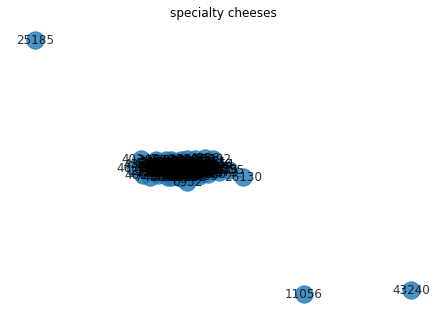

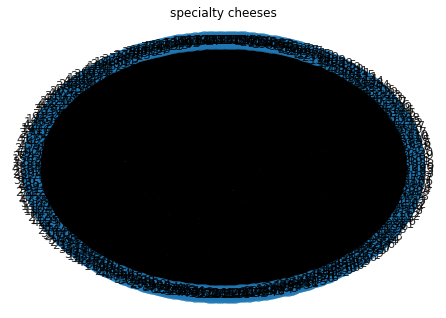

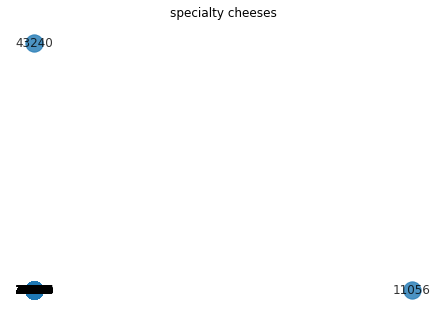

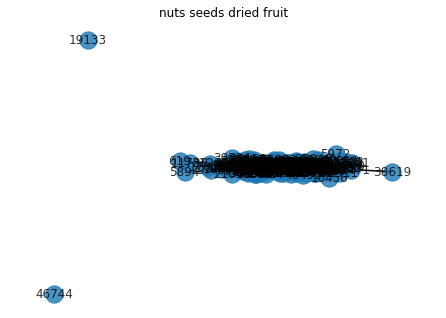

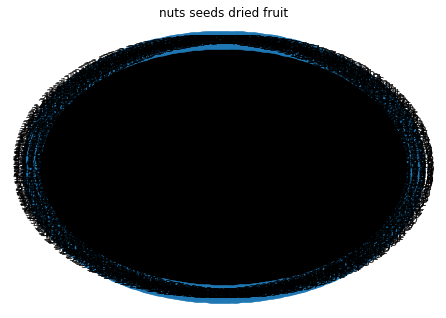

<Figure size 432x288 with 0 Axes>

In [43]:
# just have a look
c=0
for aisle in food_aisles:
    c+=1
    if c>3:
        break
    print('\n', aisle)
    #plt.figure()
    #nx.draw_spring(prod_graphs[dept], with_labels=True,  alpha = 0.8)
    #plt.title(dept)
    plt.figure()
    nx.draw(prod_graphs[aisle], with_labels=True,  alpha = 0.8)
    plt.title(aisle)
    plt.figure()
    nx.draw_circular(prod_graphs[aisle], with_labels=True,  alpha = 0.8)
    plt.title(aisle)
    plt.figure()
    nx.draw_spectral(prod_graphs[aisle], with_labels=True,  alpha = 0.8)
    plt.title(aisle)


In [75]:
spc = make_final_graph(prod_graphs["yogurt"], threshold_quantile=.3)

None
Lost products: 16 of 1026
Avg shortest Path: 1.8894935677908722
Avg weighted shortest Path: 0.02055234090705616


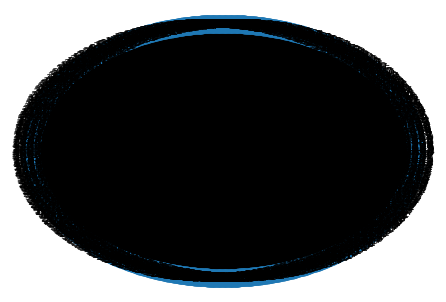

In [76]:
nx.draw_circular(spc, with_labels=True,  alpha = 0.8)

for dept in food_depts:
    lst = sorted(components.connected_components(prod_graphs[dept]), key=len, reverse=True)
    print(dept, ':')
    for g in lst[1:]:
        for p in g:
            print(by_dept[dept][by_dept[dept].product_id==p]['product_name'])
    print('\n')

dept = 'bulk'
edges = [(u, v, d['weight']) for (u, v, d) in prod_graphs[dept].edges(data=True)]
#np.mean([(u, v) for (u, v, d) in prod_graphs[dept].edges(data=True) if d['weight'] > 0.5])
edges_test = set()
for (u,v,w) in edges:
    if (v,u) in edges_test:
        print('double')
        break
    else:
        edges_test.add((u,v))

In [61]:
def look_at_edges(G):
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)] # if d['weight'] < 200
    plt.hist(edge_weights, bins=100, log=True)
    print(np.quantile(edge_weights, [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 0.99]))

[1.000000e+00 1.500000e+00 2.000000e+00 4.000000e+00 7.000000e+00
 1.500000e+01 8.100000e+01 1.428200e+03 7.558396e+04]


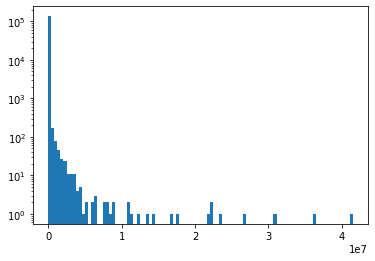

In [63]:
look_at_edges(prod_graphs["yogurt"])

array([1.913e+03, 3.550e+02, 3.080e+02, 1.440e+02, 1.410e+02, 8.700e+01,
       6.900e+01, 1.060e+02, 4.800e+01, 5.100e+01, 4.700e+01, 2.700e+01,
       2.200e+01, 3.500e+01, 2.600e+01, 1.800e+01, 1.700e+01, 3.000e+01,
       1.900e+01, 2.700e+01, 1.400e+01, 1.900e+01, 1.700e+01, 2.100e+01,
       9.000e+00, 1.100e+01, 1.900e+01, 9.000e+00, 2.100e+01, 1.400e+01,
       1.000e+00, 1.000e+01, 7.000e+00, 4.000e+00, 8.000e+00, 1.000e+01,
       9.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 0.000e+00,
       8.000e+00, 8.000e+00, 1.000e+00, 6.000e+00, 1.100e+01, 6.000e+00,
       8.000e+00, 5.000e+00, 5.000e+00, 2.000e+00, 1.100e+01, 1.000e+00,
       5.000e+00, 2.000e+00, 8.000e+00, 1.000e+00, 6.000e+00, 4.000e+00,
       2.000e+00, 4.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 7.000e+00,
       5.000e+00, 1.000e+00, 5.000e+00, 1.000e+00, 5.000e+00, 0.000e+00,
       8.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
       0.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 

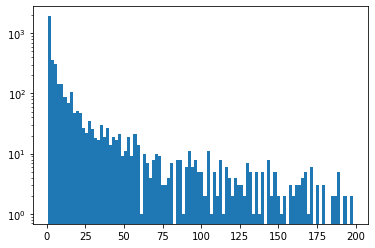

In [58]:
plt.hist(edge_weights, bins=100, log=True)[0]

In [21]:
def make_final_graph(G, aisle='None', threshold_quantile=0.3, verbose=False,save=False):
    print(aisle)
    #thresholded = nx.Graph(((u, v, d) for (u, v, d) in G.edges(data=True) if d['weight'] >= 10))
    #print('Avg shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded))
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
    lost = len(G)
    threshold_quantile = 2 * threshold_quantile
    stop = False
    threshold = 0
    while lost > 0.15 * len(G) and not stop:
        threshold_quantile = threshold_quantile / 2
        new_threshold = np.quantile(edge_weights, threshold_quantile)
        if threshold == new_threshold:
            stop=True
        else:
            threshold = new_threshold
        #print('quantile:', threshold_quantile, '; threshold:', threshold)
        thresholded_inv_edges = []
        C=0
        for (u, v, d) in G.edges(data=True):
            C+=1
            #if not C%50:
                #print(C, threshold_quantile)
            if d['weight'] > threshold:
                nd = d.copy()
                nd['weight'] = 1. / d['weight']
                thresholded_inv_edges.append((u,v,nd))
            #else:
            #    print('Too small', d['weight'])
        thresholded_inv = nx.Graph(thresholded_inv_edges)
        lost = len(G)-len(thresholded_inv)
    print('Lost products: {} of {}'.format(len(G)-len(thresholded_inv), len(G)))
    print("Used quantile: {}".format(threshold_quantile))
    #print(nx.info(thresholded_inv))
    if verbose:
        print('Avg shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded_inv))
        print('Avg weighted shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded_inv, weight='weight'))
    if save:
        nx.write_gpickle(thresholded_inv, 'thresholded_inv_'+aisle+'.gpk')
    return thresholded_inv
    
    #print(nx.info(prod_graphs[dept]))
    #print(nx.info(thresholded))

[len(c) for c in sorted(components.connected_components(thresholded), key=len, reverse=True)]

In [22]:
for aisle in food_aisles:
    make_final_graph(nx.read_gpickle('prod_graphs_'+aisle+'.gpk'), aisle, save=True)
    print('Done', aisle)
    print()

fresh dips tapenades
Lost products: 19 of 327
Used quantile: 0.3
Done fresh dips tapenades

soup broth bouillon
Lost products: 29 of 737
Used quantile: 0.3
Done soup broth bouillon

frozen juice
Lost products: 8 of 47
Used quantile: 0.01875
Done frozen juice

ice cream toppings
Lost products: 13 of 85
Used quantile: 0.0046875
Done ice cream toppings

water seltzer sparkling water
Lost products: 13 of 344
Used quantile: 0.3
Done water seltzer sparkling water

spirits
Lost products: 17 of 195
Used quantile: 0.3
Done spirits

red wines
Lost products: 19 of 232
Used quantile: 0.3
Done red wines

baking ingredients
Lost products: 28 of 623
Used quantile: 0.3
Done baking ingredients

packaged cheese
Lost products: 14 of 891
Used quantile: 0.3
Done packaged cheese

beers coolers
Lost products: 32 of 385
Used quantile: 0.3
Done beers coolers

juice nectars
Lost products: 42 of 792
Used quantile: 0.3
Done juice nectars

frozen meals
Lost products: 16 of 880
Used quantile: 0.3
Done frozen meals


Find which are target products

In [92]:
by_aisle['packaged produce'].size

128

In [190]:
def find_recommendation_path(source_id, G=None, aisle=None, health_thresh=2, product_scores=None, hscores=None, fscores=None, alpha=.3, beta=.2):
    if G is None:
        G = nx.read_gpickle('thresholded_inv_'+aisle+'.gpk')
    if product_scores is None:
        product_scores = pd.read_pickle('product_scores')
    #if hscores is None:
    #    hscores = pd.read_pickle('prod_healthiness.pk')
    targets = set()
    for x in G.nodes:
        if x in product_scores.index and product_scores.at[x, "healthiness"] >= health_thresh:
            targets.add(x)
        #else:
        #    print(product_scores.at[x, "healthiness"])
    #targets = {x for x in G.nodes if x in product_scores.index and product_scores.at[x, "healthiness"] >= health_thresh}
    #print(sorted(lst))
    #print(sorted(G.nodes))
    print('Nb of targets:', len(targets))
    #print(targets)
    # do not allow paths through even less healthy products:
    G_ok = G.subgraph({x for x in G.nodes if x in product_scores.index and product_scores.at[x, "healthiness"] >= product_scores.at[source_id, "healthiness"]})
    pred, lengths = nx.dijkstra_predecessor_and_distance(G_ok, source_id, weight='weight')
    candidates = [(-np.inf, None)]
    sep = []
    for candidate in targets:
        if candidate not in lengths:
            sep.append(candidate)
        if candidate in lengths and - lengths[candidate] > candidates[0][0]:   # ie candidate is closer than all current candidates
            if len(candidates) >= 10:
                hp.heappop(candidates)
            hp.heappush(candidates, (- lengths[candidate], candidate))
    #if fscores is None:
    #    fscores = pd.read_pickle('fidelity_scores.pk')
    if len(sep) == len(targets):
        print("not connected to a healthy product")
        return
    rec = (0, None)
    fids = []
    dists = []
    healths = []
    if candidates == [(-np.inf, None)]:
        print('No path to healthy products')
        return
    for (mdist, candidate) in candidates:
        if mdist == -np.inf:
            continue
        fids.append(product_scores.at[candidate, 'fidelity'])
        dists.append(- mdist)
        healths.append(product_scores.at[candidate, 'healthiness'])
    max_fid = max(fids)
    min_fid = min(fids)
    max_dist = max(dists)
    min_dist = min(dists)
    max_health = max(healths)
    min_health = min(healths)
    for (mdist, candidate) in candidates:
        if mdist == -np.inf:
            continue
        fid = ((product_scores.at[candidate, 'fidelity'] - min_fid) / (max_fid - min_fid)) if max_fid != min_fid else 0
        dist = ((max_dist + mdist) / (max_dist - min_dist)) if max_dist != min_dist else 0
        health = ((product_scores.at[candidate, "healthiness"] - min_health) / (max_health - min_health)) if max_health != min_health else 0
        score = (1+health)**alpha * (1+fid)**beta * (1+dist)**(1-alpha-beta)
        if score > rec[0]:
            rec = (score, candidate)
    orig = rec[1]
    path = [orig]
    while orig != source_id:
        orig = pred[orig][0]
        path.append(orig)
    return path

In [162]:
find_recommendation_path(3265, aisle='packaged produce', product_scores=product_scores)

Nb of targets: 4


[21385, 12341, 3265]

In [192]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id
0,473747,1,prior,3,3,12,21.0,196
1,473747,1,prior,3,3,12,21.0,12427
2,473747,1,prior,3,3,12,21.0,10258
3,473747,1,prior,3,3,12,21.0,25133
4,473747,1,prior,3,3,12,21.0,30450


In [194]:
# Find real recommendations
#history = pd.read_csv('data/order_products__prior.csv', sep=',')
orders_products = pd.read_pickle('orders_products.pk')
with open('THE_GOOD_users_cluster.pk', 'rb') as f:
    users_cluster = pk.load(f)
unhealthy = set(u+1 for u in range(len(users_cluster)) if users_cluster[u]==0)
unhealthy_orders = orders_products[orders_products.user_id.isin(unhealthy)]
unhealthy_food_orders = unhealthy_orders[unhealthy_orders.apply(lambda row: prod_lit.at[row.product_id, 'aisle'] in food_aisles, axis=1)]

In [199]:
some_unhealthy_orders = unhealthy_orders.sample(100)[['order_id', 'user_id', 'product_id']]

In [200]:
some_unhealthy_orders.head()

,order_id,user_id,product_id
2395924,1415083,34573,26620
5887249,222033,84623,19333
11384403,850612,164075,35413
11647548,387635,168070,15700
6889329,1325971,98979,17706


In [188]:
prod_lit = products_litteral.set_index('product_id')
prod_lit.head()

,product_name,aisle,department
product_id,,,
1,Chocolate Sandwich Cookies,cookies cakes,snacks
78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
102,Danish Butter Cookies,cookies cakes,snacks
172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [201]:
for _, row in some_unhealthy_orders.iterrows():
    try:
        print('For user ', row.user_id)
        print('Path from', prod_lit.at[row.product_id, 'product_name'], 'with healthiness', product_scores.at[row.product_id, 'healthiness'])
        path = find_recommendation_path(row.product_id, aisle=prod_lit.at[row.product_id, 'aisle'], product_scores=product_scores)
        target = path[0]
        print('To', prod_lit.at[target, 'product_name'], 'with healthiness', product_scores.at[target, 'healthiness'])
        print()
    except:
        print('============================= Echec: For user ', row.user_id)
        print('Path from', prod_lit.at[row.product_id, 'product_name'], 'with healthiness', product_scores.at[row.product_id, 'healthiness'])
        print()
        

For user  34573
Path from Peach Pear Flavored Sparkling Water with healthiness 1.8428691983122363
Nb of targets: 80
To Italian Sparkling Mineral Water with healthiness 2.645234133586879

For user  84623
Path from Select 100% Whole Wheat Sandwich Rolls with healthiness 1.5688622754491017
Nb of targets: 65
To Hamburger Buns Whole Grain with healthiness 2.212121212121212

For user  164075
Path from Freshly made pasta layered between a rich meat sauce and topped with Real Mozzarella cheese Lasagna with Meat & Sauce with healthiness -0.03879310344827586
Nb of targets: 49
To Organic Brown Rice with healthiness 2.5913242009132422

For user  168070
Path from Cheddar Cheese Nut Thins Cracker Snacks with healthiness 1.9688412852969814
Nb of targets: 272
To Hint Of Sea Salt Almond Nut Thins with healthiness 2.2302728072748605

For user  98979
Path from Organic Whole Grain Wheat English Muffins with healthiness 2.3905109489051095
Nb of targets: 65
To Organic Sprouted Wheat Bagels with healthiness 

To Sea Salt Pita Chips with healthiness 2.2629550321199146

For user  310
Path from Strawberry Watermelon Liquid Water Enhancer with healthiness 0.2777777777777778
Nb of targets: 42
To Fit Artic Grape Energy Drink Drops with healthiness 2.4324324324324325

For user  19432
Path from Toasted Coconut Almondmilk Blend with healthiness 2.339177924691003
Nb of targets: 175
To Toasted Coconut Almondmilk Blend with healthiness 2.339177924691003

For user  33216
Path from Strawberries with healthiness 1.9130029007441038
Nb of targets: 230
To Organic Avocado with healthiness 2.676720345399112

For user  118878
Path from Zero Calorie Cola with healthiness -0.49011358855700465
Nb of targets: 52
To Premium Indian Tonic Water with healthiness 2.356394129979036

For user  199535
Path from Roasted Vegetable Ravioli with healthiness 2.0434782608695654
Nb of targets: 66
To Asparagus & Gruyere Ravioli with healthiness 2.953488372093023

For user  148367
Path from Organic Shredded Carrots with healthiness

To Organic Hass Avocado with healthiness 2.670946515943985

For user  128456
Path from Regular with healthiness 0.24437299035369775
Nb of targets: 52
To Premium Indian Tonic Water with healthiness 2.356394129979036

For user  72436
Path from Classic Mix Variety with healthiness 0.2275320970042796
Nb of targets: 318
To Sea Salt Pita Chips with healthiness 2.2629550321199146

For user  88800
Path from Lemon Fruit & Nut Food Bar with healthiness 2.1363636363636362
Nb of targets: 257
To Banana Bread Fruit & Nut Bar with healthiness 2.425531914893617



In [ ]:
For user  307
Path from Organic Coconut Water with healthiness 0.3990885416666667
Nb of targets: 80
To Italian Sparkling Mineral Water with healthiness 2.645234133586879
For user  16433
Path from Broccoli Bunch with healthiness 2.078125
Nb of targets: 519
To Broccoli Bunch with healthiness 2.078125
For user  14179
Path from Water Mineral with healthiness -0.011093502377179081
Nb of targets: 80
To Italian Sparkling Mineral Water with healthiness 2.645234133586879
For user  202355
Path from Simply 100 Crunch Blueberry Cookie Crumble Non-Fat Greek Yogurt with healthiness 0.30303030303030304
Nb of targets: 449
To Organic Plain Whole Milk Yogurt with healthiness 2.7170563230605738

For user  307
Path from Organic Coconut Water with healthiness 0.3990885416666667
Nb of targets: 80
To Italian Sparkling Mineral Water with healthiness 2.645234133586879
For user  16433
Path from Broccoli Bunch with healthiness 2.078125
Nb of targets: 519
To Broccoli Bunch with healthiness 2.078125
For user  14179
Path from Water Mineral with healthiness -0.011093502377179081
Nb of targets: 80
To Italian Sparkling Mineral Water with healthiness 2.645234133586879
For user  202355
Path from Simply 100 Crunch Blueberry Cookie Crumble Non-Fat Greek Yogurt with healthiness 0.30303030303030304
Nb of targets: 449
To Organic Plain Whole Milk Yogurt with healthiness 2.7170563230605738
For user  64793
Path from Super B-Complex Key B Vitamins + Vitamin C Dietary Supplement Tablets with healthiness -0.6
Echec: For user  64793
Path from Super B-Complex Key B Vitamins + Vitamin C Dietary Supplement Tablets with healthiness -0.6
For user  197225
Path from Dairy Free Unsweetened Coconut Milk with healthiness 2.631650750341064
Nb of targets: 175
To Organic Coconut Milk with healthiness 3.3096594673380153
For user  94446
Path from Vanilla Almond Pecan Oatmeal Bowl with healthiness 1.0727272727272728
Nb of targets: 142
To Apple Cinnamon Pecan Oatmeal Cup with healthiness 2.3859649122807016
For user  59931
Path from Coconut Kale & Cacao Organic Superfoods Bar with healthiness 2.4545454545454546
Nb of targets: 257
To Superfood Cranberry, Almond & Lucuma Seedbar with healthiness 3.0
For user  151541
Path from Natural Premium Coconut Water with healthiness 2.385560215698023
Nb of targets: 270
To Organic Orange Juice with healthiness 2.5098892405063293
For user  157312
Path from Fresh Spinach with healthiness 2.1587301587301586
Nb of targets: 326
To Fresh Spinach with healthiness 2.1587301587301586
For user  100948
Path from Hass Avocado with healthiness 2.766289825282631
Nb of targets: 519
To Hass Avocado with healthiness 2.766289825282631
For user  89598
Path from Select Natural Applewood Smoked Turkey Breast with healthiness 1.0
Nb of targets: 119
To Organic Roasted Turkey Breast with healthiness 2.3684143385635923
For user  157844
Path from Penne Pasta with healthiness 1.5420780441937
Nb of targets: 318
To Rigatoni Pasta with healthiness 2.3333333333333335
For user  184617
Path from Shoestring Fries with healthiness 2.693464052287582
Nb of targets: 84
To Mini Vegetable Spring Rolls with healthiness 3.085714285714286
For user  32635
Path from Garlic Salt with healthiness 1.7508532423208192
Nb of targets: 529
To Oregano with healthiness 3.287958115183246
For user  8090
Path from Premium Chunk Light in Vegetable Oil Tuna with healthiness 1.9428571428571428
Nb of targets: 124
To Tonno, Tuna Solid White in Olive Oil with healthiness 2.9444444444444446
For user  93512
Path from Bacon & Bleu Chopped Salad Kit with healthiness 0.9534883720930233
Nb of targets: 326
To Baby Spinach with healthiness 2.705372616984402
For user  93392
Path from Unrefined Virgin Coconut Oil with healthiness 2.933384972889233
Nb of targets: 234
To Toasted Sesame Seed Oil with healthiness 3.356803044719315
For user  198446
Path from Cara Cara Oranges, Bag with healthiness 2.608695652173913
Nb of targets: 230
To Cara Cara Oranges, Bag with healthiness 2.608695652173913
For user  188523
Path from Original Whipped Topping with healthiness 0.9015625
Nb of targets: 16
To Pastry Kitchens Classic Puff Pastry with healthiness 3.2208835341365463

In [163]:
healthiness_per_aisle['packaged produce'][healthiness_per_aisle['packaged produce'].product_id==21385]

,product_id,product_name,aisle,department,healthiness,count,fidelity
18,21385,Butter Lettuce,packaged produce,produce,2.194175,618,0.807941


In [153]:
# mean healthiness per aisle
healthiness_per_aisle = {}
for aisle in food_aisles:
    healthiness_per_aisle[aisle] = pd.merge(by_aisle[aisle], product_scores, left_on='product_id', right_on='product_id')

In [139]:
for aisle in food_aisles:
    print(aisle, healthiness_per_aisle[aisle].mean()['healthiness'])
    print("====================")

fresh dips tapenades 1.79067887398118
soup broth bouillon 1.3941966800804526
frozen juice 1.0399514338822409
ice cream toppings 1.0968692866158418
water seltzer sparkling water 1.239112564552592
spirits 0.9567987921439435
red wines 1.2536254665546902
baking ingredients 2.0264213261744666
packaged cheese 1.6896491572413097
beers coolers 0.7434820461027672
juice nectars 1.3837646252983895
frozen meals 0.26754207134166325
breakfast bakery 1.3105598454455978
tea 1.6290213434255987
tortillas flat bread 2.0540074158785098
other creams cheeses 1.5916253128196411
energy granola bars 1.4709370754426256
chips pretzels 1.326160376033867
preserved dips spreads 1.7477633195423563
hot cereal pancake mixes 1.801588915528622
bulk dried fruits vegetables 2.2577091884944296
milk 1.668663495031789
frozen dessert 0.9712701079368742
dry pasta 2.3914223590514916
eggs 2.1004976545045837
specialty wines champagnes 1.1275023532279624
packaged vegetables fruits 1.8773111512029206
hot dogs bacon sausage 1.679239

In [119]:
by_aisle['fresh vegetables'].head()

,product_id,product_name,aisle,department
41744,45,European Cucumber,fresh vegetables,produce
41745,99,Local Living Butter Lettuce,fresh vegetables,produce
41746,306,Gold Potatoes,fresh vegetables,produce
41747,312,Juicing Carrots,fresh vegetables,produce
41748,391,Organic Yukon Gold Potato Bag,fresh vegetables,produce


In [140]:
for aisle in food_aisles:#['packaged produce']:#
    t = 0
    g = 0
    lst = []
    for ind in by_aisle[aisle]['product_id']:
        if ind in product_scores.index:
            lst.append(product_scores.at[ind, 'healthiness'])
        if ind in product_scores.index and product_scores.at[ind, 'healthiness']>=2:
            g += 1
        t+=1
    #print(by_aisle[aisle]['product_id'])
    print(aisle, float(g)/t, g, t)
    #print(sorted(lst))

fresh dips tapenades 0.5107033639143731 167 327
soup broth bouillon 0.3378561736770692 249 737
frozen juice 0.1702127659574468 8 47
ice cream toppings 0.24705882352941178 21 85
water seltzer sparkling water 0.25290697674418605 87 344
spirits 0.15897435897435896 31 195
red wines 0.24568965517241378 57 232
baking ingredients 0.5682182985553772 354 623
packaged cheese 0.43546576879910215 388 891
beers coolers 0.13246753246753246 51 385
juice nectars 0.3522727272727273 279 792
frozen meals 0.05909090909090909 52 880
breakfast bakery 0.29646017699115046 67 226
tea 0.38031319910514544 340 894
tortillas flat bread 0.5601659751037344 135 241
other creams cheeses 0.41361256544502617 79 191
energy granola bars 0.3173076923076923 264 832
chips pretzels 0.32659251769464104 323 989
preserved dips spreads 0.45454545454545453 120 264
hot cereal pancake mixes 0.4884488448844885 148 303
bulk dried fruits vegetables 0.6666666666666666 8 12
milk 0.4279835390946502 104 243
frozen dessert 0.178571428571428

In [38]:
product_scores.head()

,healthiness,count,fidelity
product_id,,,
1,2.739645,507,0.679629
2,0.333333,21,0.093217
3,1.338710,62,1.630632
4,3.111111,90,0.975122
5,-0.500000,4,1.829932


In [33]:
by_aisle.keys()

dict_keys(['packaged produce', 'tofu meat alternatives', 'fresh pasta', 'doughs gelatins bake mixes', 'nuts seeds dried fruit', 'meat counter', 'bread', 'frozen breakfast', 'milk', 'seafood counter', 'energy granola bars', 'coffee', 'packaged meat', 'bulk dried fruits vegetables', 'dry pasta', 'tea', 'instant foods', 'preserved dips spreads', 'frozen meals', 'other creams cheeses', 'bulk grains rice dried goods', 'marinades meat preparation', 'hot cereal pancake mixes', 'canned meat seafood', 'salad dressing toppings', 'specialty wines champagnes', 'fresh herbs', 'trail mix snack mix', 'granola', 'fruit vegetable snacks', 'spreads', 'breakfast bars pastries', 'prepared soups salads', 'butter', 'oils vinegars', 'buns rolls', 'crackers', 'fresh fruits', 'chips pretzels', 'cookies cakes', 'specialty cheeses', 'poultry counter', 'bakery desserts', 'grains rice dried goods', 'soy lactosefree', 'hot dogs bacon sausage', 'ice cream ice', 'packaged cheese', 'packaged vegetables fruits', 'packa

In [51]:
by_aisle['packaged produce']

,product_id,product_name,aisle,department
42781,1672,English Cucumbers,packaged produce,produce
42782,3265,Mini Seedless Watermelon Pack,packaged produce,produce
42783,4724,Broccoli Florettes,packaged produce,produce
42784,5068,Cauliflower Florets,packaged produce,produce
42785,5985,Red Bell Peppers,packaged produce,produce
42786,6184,Clementines,packaged produce,produce
42787,7252,Deep Green Blends Kale,packaged produce,produce
42788,8048,Packaged Grape Tomatoes,packaged produce,produce
42789,8571,Baby Cucumbers,packaged produce,produce
42790,8803,Fully Husked & Trimmed Super Sweet Corn,packaged produce,produce


In [134]:
product_scores = pd.read_pickle('GOOD_product_scores.pk')


In [135]:
product_scores.head()

,healthiness,count,fidelity
product_id,,,
1,-0.090730,507,0.679629
2,2.476190,21,0.093217
3,1.306452,62,1.630632
4,-0.166667,90,0.975122
5,3.250000,4,1.829932


In [132]:
product_scores.columns=['healthiness', 'count', 'fidelity']

In [133]:
product_scores.set_index(product_scores.index.astype(int)).to_pickle('GOOD_product_scores.pk')

sp = shortest_paths.dense.floyd_warshall(thresholded)
sp2 = {(u,v): d for u, sp_d in sp.items() for v, d in sp_d.items()}
#print(max(sp.values()), min(sp.values()))

In [176]:
products_litteral[products_litteral.aisle == 'packaged produce'].head(50)

NameError: name 'products_litteral' is not defined

In [177]:
products_litteral[products_litteral.aisle == 'packaged vegetables fruits'].head(50)

,product_id,product_name,aisle,department
41129,31,White Pearl Onions,packaged vegetables fruits,produce
41130,43,Organic Clementines,packaged vegetables fruits,produce
41131,66,European Style Spring Mix,packaged vegetables fruits,produce
41132,89,Yogurt Fruit Dip Sliced Apples,packaged vegetables fruits,produce
41133,120,Cauliflower Florettes,packaged vegetables fruits,produce
41134,142,Arugula Salad,packaged vegetables fruits,produce
41135,343,Organic Whole Peeled Baby Carrots,packaged vegetables fruits,produce
41136,347,"Vegetable Salad Kit, Sweet Kale",packaged vegetables fruits,produce
41137,364,Greener Selection Salad,packaged vegetables fruits,produce
41138,380,Clementine Bag,packaged vegetables fruits,produce
